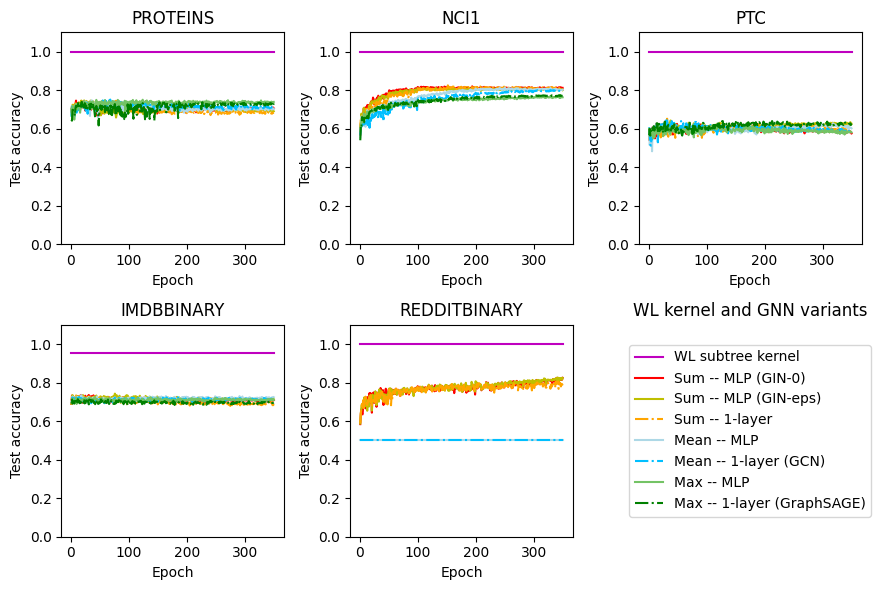

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Based on https://www.color-meanings.com/shades-of-blue-color-names-html-hex-rgb-codes/
SKY_BLUE = (173/255, 216/255, 230/255)
CAPRI_BLUE = (0, 191/255, 1)

# Based on https://www.colorsexplained.com/shades-of-green-color-names/
MANTIS_GREEN = (116/255, 195/255, 101/255)

SUBPLOTS_TITLES = [['PROTEINS', 'NCI1', 'PTC'], ['IMDBBINARY', 'REDDITBINARY']]
WL_SUBTREE_KERNEL_ACCURACIES = [
    [np.full(350, 1.0), np.full(350, 1.0), np.full(350, 1.0)], 
    [np.full(350, 0.953), np.full(350, 1.0)]
]
EPOCHS = np.array(range(1, 351))


def plot_data(
    ax, title, x, y1, y2, y3, y4, y5, y6,
    color1='m', linestyle1='-',
    color2='r', linestyle2='-',
    color3='y', linestyle3='-',
    color4='orange', linestyle4='-.',
    color5=SKY_BLUE, linestyle5='-',
    color6=CAPRI_BLUE, linestyle6='-.',
    **kwargs
):
    ax.plot(x, y1, label='WL subtree kernel', color=color1, linestyle=linestyle1)
    ax.plot(x, y2, label='Sum -- MLP (GIN-0)', color=color2, linestyle=linestyle2)
    ax.plot(x, y3, label='Sum -- MLP (GIN-eps)', color=color3, linestyle=linestyle3)
    ax.plot(x, y4, label='Sum -- 1-layer', color=color4, linestyle=linestyle4)
    ax.plot(x, y5, label='Mean -- MLP', color=color5, linestyle=linestyle5)
    ax.plot(x, y6, label='Mean -- 1-layer (GCN)', color=color6, linestyle=linestyle6)

    if 'y7' in kwargs:
        ax.plot(x, kwargs['y7'], label='Max -- MLP', color=MANTIS_GREEN, linestyle='-')
    if 'y8' in kwargs:
        ax.plot(x, kwargs['y8'], label='Max -- 1-layer (GraphSAGE)', color='g', linestyle='-.')

    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Test accuracy")
    ax.set_ylim([0, 1.1])


def main():
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(9, 6))

    # Plot data on each subplot
    for i in range(2):
        for j in range(3):
            # Skip the bottom right subplot for the legend
            if (i, j) != (1, 2):
                title = SUBPLOTS_TITLES[i][j]
                y2 = np.loadtxt(f'outputs/sum_mlp_0_{title}')[:, 3]
                y3 = np.loadtxt(f'outputs/sum_mlp_eps_{title}')[:,3]
                y4 = np.loadtxt(f'outputs/sum_1_layer_{title}')[:, 3]
                y5 = np.loadtxt(f'outputs/mean_mlp_{title}')[:, 3]
                y6 = np.loadtxt(f'outputs/mean_1_layer_{title}')[:, 3]

                # Notice that REDDITBINARY graph does not contain Max-MLP and Max-1-layer lines
                if title != 'REDDITBINARY':
                    y7 = np.loadtxt(f'outputs/max_mlp_{title}')[:, 3]
                    y8 = np.loadtxt(f'outputs/max_1_layer_{title}')[:, 3]
                    plot_data(axs[i, j], title, EPOCHS, WL_SUBTREE_KERNEL_ACCURACIES[i][j], y2, y3, y4, y5, y6, y7=y7, y8=y8)
                else:
                    plot_data(axs[i, j], title, EPOCHS, WL_SUBTREE_KERNEL_ACCURACIES[i][j], y2, y3, y4, y5, y6)

    # Use the bottom right subplot for the legend
    # Hide the axes
    axs[1, 2].axis('off')
    # Get the handles and labels from one of the plots which contains all eight lines
    handles, labels = axs[0, 0].get_legend_handles_labels()
    axs[1, 2].legend(handles, labels, loc='center')
    axs[1, 2].set_title('WL kernel and GNN variants')

    # Display the figure
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()

In [108]:
import numpy as np
import pandas as pd

# Dataset titles and accuracies
DATASET_TITLES = [ 'MUTAG', 'PROTEINS', 'PTC', 'NCI1', 'IMDBBINARY', 'IMDBMULTI', 'COLLAB', 'REDDITMULTI5K', 'REDDITBINARY']
WL_SUBTREE_KERNEL_ACCURACIES = {
    'IMDBMULTI': np.full(350, 0.953),
    'IMDBBINARY': np.full(350, 0.95),
    'REDDITBINARY': np.full(350, 1.0),
    'RDT-M5K': np.full(350, 1.0),
    'COLLAB': np.full(350, 1.0),
    'MUTAG': np.full(350, 1.0),
    'PROTEINS': np.full(350, 1.0),
    'PTC': np.full(350, 1.0),
    'NCI1': np.full(350, 1.0),
    'REDDITMULTI5K': np.full(350, 1.0)
}

def load_data(title):
    y2 = np.loadtxt(f'outputs/sum_mlp_0_{title}')[:, 3]
    y3 = np.loadtxt(f'outputs/sum_mlp_eps_{title}')[:,3]
    y4 = np.loadtxt(f'outputs/sum_1_layer_{title}')[:, 3]
    y5 = np.loadtxt(f'outputs/mean_mlp_{title}')[:, 3]
    y6 = np.loadtxt(f'outputs/mean_1_layer_{title}')[:, 3]
    if title not in ['REDDITMULTI5K', 'REDDITBINARY', 'COLLAB']:
        y7 = np.loadtxt(f'outputs/max_mlp_{title}')[:, 3]
        y8 = np.loadtxt(f'outputs/max_1_layer_{title}')[:, 3]
        return y2, y3, y4, y5, y6, y7, y8
    return y2, y3, y4, y5, y6

def main():
    results = []

    for title in DATASET_TITLES:
        wl_accuracies = WL_SUBTREE_KERNEL_ACCURACIES[title]
        data = load_data(title)

        if title not in ['REDDITMULTI5K', 'REDDITBINARY', 'COLLAB']:
            y2, y3, y4, y5, y6, y7, y8 = data
            avg_accuracies = [
                np.mean(wl_accuracies), np.mean(y2), np.mean(y3), np.mean(y4),
                np.mean(y5), np.mean(y6), np.mean(y7), np.mean(y8)
            ]
        else:
            y2, y3, y4, y5, y6 = data
            avg_accuracies = [
                np.mean(wl_accuracies), np.mean(y2), np.mean(y3), np.mean(y4),
                np.mean(y5), np.mean(y6), None, None
            ]

        results.append([title] + avg_accuracies)

    columns = [
        'Dataset', 'WL subtree kernel', 'Sum -- MLP (GIN-0)', 'Sum -- MLP (GIN-eps)',
        'Sum -- 1-layer', 'Mean -- MLP', 'Mean -- 1-layer (GCN)',
        'Max -- MLP', 'Max -- 1-layer (GraphSAGE)'
    ]
    df = pd.DataFrame(results, columns=columns)
    
    # Print the table
    print(df)
    return df

if __name__ == '__main__':
    df = main()


         Dataset  WL subtree kernel  Sum -- MLP (GIN-0)  Sum -- MLP (GIN-eps)  \
0          MUTAG              1.000            0.846232              0.846065   
1       PROTEINS              1.000            0.702188              0.698688   
2            PTC              1.000            0.594976              0.611301   
3           NCI1              1.000            0.798399              0.790900   
4     IMDBBINARY              0.950            0.711731              0.716911   
5      IMDBMULTI              0.953            0.487962              0.492638   
6         COLLAB              1.000            0.075115              0.074941   
7  REDDITMULTI5K              1.000            0.442784              0.439501   
8   REDDITBINARY              1.000            0.771349              0.773790   

   Sum -- 1-layer  Mean -- MLP  Mean -- 1-layer (GCN)  Max -- MLP  \
0        0.856132     0.735138               0.663672    0.777287   
1        0.696517     0.706971               0.7188

In [113]:
import numpy as np
import pandas as pd

# Dataset titles and accuracies
DATASET_TITLES = [ 'MUTAG', 'PROTEINS', 'PTC', 'NCI1', 'IMDBBINARY', 'IMDBMULTI', 'COLLAB', 'REDDITMULTI5K', 'REDDITBINARY']
WL_SUBTREE_KERNEL_ACCURACIES = {
    'IMDBMULTI': np.full(350, 0.953),
    'IMDBBINARY': np.full(350, 0.95),
    'REDDITBINARY': np.full(350, 1.0),
    'RDT-M5K': np.full(350, 1.0),
    'COLLAB': np.full(350, 1.0),
    'MUTAG': np.full(350, 1.0),
    'PROTEINS': np.full(350, 1.0),
    'PTC': np.full(350, 1.0),
    'NCI1': np.full(350, 1.0),
    'REDDITMULTI5K': np.full(350, 1.0)
}

def load_data(title):
    y2 = np.loadtxt(f'outputs/sum_mlp_0_{title}')[:, 3]
    y3 = np.loadtxt(f'outputs/sum_mlp_eps_{title}')[:,3]
    y4 = np.loadtxt(f'outputs/sum_1_layer_{title}')[:, 3]
    y5 = np.loadtxt(f'outputs/mean_mlp_{title}')[:, 3]
    y6 = np.loadtxt(f'outputs/mean_1_layer_{title}')[:, 3]
    if title not in ['REDDITMULTI5K', 'REDDITBINARY', 'COLLAB']:
        y7 = np.loadtxt(f'outputs/max_mlp_{title}')[:, 3]
        y8 = np.loadtxt(f'outputs/max_1_layer_{title}')[:, 3]
        return y2, y3, y4, y5, y6, y7, y8
    return y2, y3, y4, y5, y6

def calculate_mean_std(values):
    return np.mean(values) * 100, np.std(values) * 100

def main():
    results = []

    for title in DATASET_TITLES:
        wl_accuracies = WL_SUBTREE_KERNEL_ACCURACIES[title]
        data = load_data(title)

        if title not in ['REDDITMULTI5K', 'REDDITBINARY', 'COLLAB']:
            y2, y3, y4, y5, y6, y7, y8 = data
            avg_std_accuracies = [
                f"{calculate_mean_std(wl_accuracies)[0]:.2f} ± {calculate_mean_std(wl_accuracies)[1]:.2f}", 
                f"{calculate_mean_std(y2)[0]:.2f} ± {calculate_mean_std(y2)[1]:.2f}",
                f"{calculate_mean_std(y3)[0]:.2f} ± {calculate_mean_std(y3)[1]:.2f}",
                f"{calculate_mean_std(y4)[0]:.2f} ± {calculate_mean_std(y4)[1]:.2f}",
                f"{calculate_mean_std(y5)[0]:.2f} ± {calculate_mean_std(y5)[1]:.2f}",
                f"{calculate_mean_std(y6)[0]:.2f} ± {calculate_mean_std(y6)[1]:.2f}",
                f"{calculate_mean_std(y7)[0]:.2f} ± {calculate_mean_std(y7)[1]:.2f}",
                f"{calculate_mean_std(y8)[0]:.2f} ± {calculate_mean_std(y8)[1]:.2f}"
            ]
        else:
            y2, y3, y4, y5, y6 = data
            avg_std_accuracies = [
                f"{calculate_mean_std(wl_accuracies)[0]:.2f} ± {calculate_mean_std(wl_accuracies)[1]:.2f}",
                f"{calculate_mean_std(y2)[0]:.2f} ± {calculate_mean_std(y2)[1]:.2f}",
                f"{calculate_mean_std(y3)[0]:.2f} ± {calculate_mean_std(y3)[1]:.2f}",
                f"{calculate_mean_std(y4)[0]:.2f} ± {calculate_mean_std(y4)[1]:.2f}",
                f"{calculate_mean_std(y5)[0]:.2f} ± {calculate_mean_std(y5)[1]:.2f}",
                f"{calculate_mean_std(y6)[0]:.2f} ± {calculate_mean_std(y6)[1]:.2f}",
                None, None
            ]

        results.append([title] + avg_std_accuracies)

    columns = [
        'Dataset', 'WL subtree kernel', 'Sum -- MLP (GIN-0)', 'Sum -- MLP (GIN-eps)',
        'Sum -- 1-layer', 'Mean -- MLP', 'Mean -- 1-layer (GCN)',
        'Max -- MLP', 'Max -- 1-layer (GraphSAGE)'
    ]
    df = pd.DataFrame(results, columns=columns)
    
    # Print the table
    print(df)
    return df

if __name__ == '__main__':
    df = main()


         Dataset WL subtree kernel Sum -- MLP (GIN-0) Sum -- MLP (GIN-eps)  \
0          MUTAG     100.00 ± 0.00       84.62 ± 1.31         84.61 ± 1.42   
1       PROTEINS     100.00 ± 0.00       70.22 ± 1.05         69.87 ± 1.27   
2            PTC     100.00 ± 0.00       59.50 ± 1.15         61.13 ± 1.35   
3           NCI1     100.00 ± 0.00       79.84 ± 3.25         79.09 ± 3.13   
4     IMDBBINARY      95.00 ± 0.00       71.17 ± 0.72         71.69 ± 0.64   
5      IMDBMULTI      95.30 ± 0.00       48.80 ± 1.23         49.26 ± 1.27   
6         COLLAB     100.00 ± 0.00        7.51 ± 0.37          7.49 ± 0.31   
7  REDDITMULTI5K     100.00 ± 0.00       44.28 ± 2.91         43.95 ± 3.04   
8   REDDITBINARY     100.00 ± 0.00       77.13 ± 3.36         77.38 ± 3.41   

  Sum -- 1-layer   Mean -- MLP Mean -- 1-layer (GCN)    Max -- MLP  \
0   85.61 ± 1.32  73.51 ± 4.27          66.37 ± 6.62  77.73 ± 1.89   
1   69.65 ± 1.70  70.70 ± 1.20          71.88 ± 1.24  73.33 ± 1.14   
2   59.75

In [115]:
results = df.transpose()

In [122]:
results

,0,1,2,3,4,5,6,7,8
Dataset,MUTAG,PROTEINS,PTC,NCI1,IMDBBINARY,IMDBMULTI,COLLAB,REDDITMULTI5K,REDDITBINARY
WL subtree kernel,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,95.00 ± 0.00,95.30 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00
Sum -- MLP (GIN-0),84.62 ± 1.31,70.22 ± 1.05,59.50 ± 1.15,79.84 ± 3.25,71.17 ± 0.72,48.80 ± 1.23,7.51 ± 0.37,44.28 ± 2.91,77.13 ± 3.36
Sum -- MLP (GIN-eps),84.61 ± 1.42,69.87 ± 1.27,61.13 ± 1.35,79.09 ± 3.13,71.69 ± 0.64,49.26 ± 1.27,7.49 ± 0.31,43.95 ± 3.04,77.38 ± 3.41
Sum -- 1-layer,85.61 ± 1.32,69.65 ± 1.70,59.75 ± 1.24,79.19 ± 3.90,69.99 ± 1.23,48.87 ± 1.18,7.54 ± 0.31,43.59 ± 2.89,76.50 ± 3.00
Mean -- MLP,73.51 ± 4.27,70.70 ± 1.20,60.08 ± 1.54,77.28 ± 4.49,71.77 ± 0.60,48.56 ± 1.37,7.65 ± 0.32,20.00 ± 0.00,50.00 ± 0.00
Mean -- 1-layer (GCN),66.37 ± 6.62,71.88 ± 1.24,59.95 ± 1.55,75.48 ± 4.68,71.18 ± 0.62,48.03 ± 1.41,7.62 ± 0.25,20.00 ± 0.00,50.00 ± 0.00
Max -- MLP,77.73 ± 1.89,73.33 ± 1.14,58.99 ± 1.10,74.08 ± 2.68,71.03 ± 0.55,48.18 ± 1.38,None,None,None
Max -- 1-layer (GraphSAGE),78.87 ± 1.73,71.30 ± 2.07,61.61 ± 1.46,74.53 ± 3.17,69.65 ± 0.57,47.90 ± 1.31,None,None,None
